# Tomato Disease Diagnosis

In [1]:
from fastai.vision.all import *

In [2]:
Path.BASE_PATH = path = Path("/notebooks/tomatodiagnosis/data/")

## Exploratory Data Analysis

In [3]:
path.ls()

(#10) [Path('Tomato_Yellow_Leaf_Curl_Virus'),Path('healthy'),Path('Late_blight'),Path('Septoria_leaf_spot'),Path('Leaf_Mold'),Path('Spider_mites'),Path('Tomato_mosaic_virus'),Path('Early_blight'),Path('Bacterial_spot'),Path('Target_Spot')]

We have 10 classes in our dataset, 9 of these are the tomato diseases whereas the 10th class labels the tomato leaves that are healthy.

In [4]:
import os
subdir_counts = {}
for root, dirs, files in os.walk(path):
    num_files = len(files)
    if root != path and num_files > 0:
        subdir = os.path.basename(root)
        subdir_counts[subdir] = num_files
    
for subdir, count in subdir_counts.items():
    print(f"{subdir}: {count} files")

Tomato_Yellow_Leaf_Curl_Virus: 5357 files
healthy: 1591 files
Late_blight: 1909 files
Septoria_leaf_spot: 1771 files
Leaf_Mold: 952 files
Spider_mites: 1676 files
Tomato_mosaic_virus: 373 files
Early_blight: 1000 files
Bacterial_spot: 2127 files
Target_Spot: 1404 files


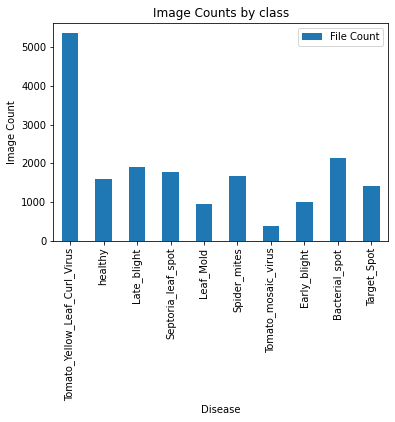

In [26]:
df = pd.DataFrame.from_dict(subdir_counts, orient="index", columns=["File Count"])
df.plot(kind="bar")

plt.title("Image Counts by class")
plt.xlabel("Disease")
plt.ylabel("Image Count")

plt.show()

The count plot above tells us the distribution of the classes i.e (`Diseases`). It is evident that some of the classes in the dataset are not well represented which implies that the model will struggle to learn how to predict 

More Data for the classes that aren't well represented can be collected to match the well represented class. Another idea could be trying out trying out some statistical technicals like over sampling or undersampling.

In [6]:
files = get_image_files(path)

(256, 256)


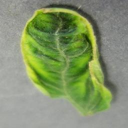

In [5]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [6]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(256, 256)    18160
dtype: int64

There is a total of 18,160 images with the same size of 256 x 256 image pixels. This image size is small and this can imply that our model might struggle while predicting new images that are of a larger size.

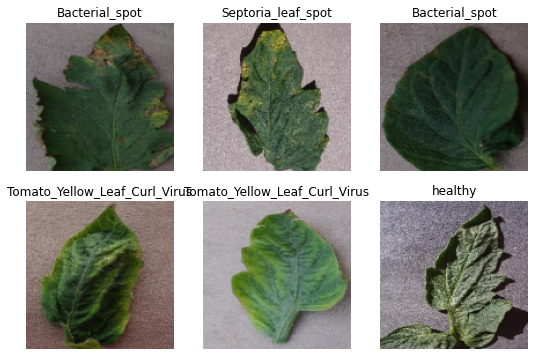

In [7]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42,
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(3, 0.01)

In [ ]:
0.01187269376196545

## Intergrating with weights and Biases

In [7]:
from fastcore.all import *
import wandb

In [8]:
# Initialize a new W&B run
run = wandb.init(project='TomatoDiseaseClassifier')

wandb: Currently logged in as: solab5. Use `wandb login --relogin` to force relogin


In [9]:
# Create a new W&B artifact
artifact_raw = wandb.Artifact('my_images', type='dataset')

In [10]:
# Loop over the image files in the data directory and add them to the artifact
image_files = get_image_files(path)
for file_path in image_files:
    # Get the subdirectory name and filename
    subdir = os.path.basename(os.path.dirname(file_path))
    filename = os.path.basename(file_path)
    
    # Add the file to the artifact
    artifact_raw.add_file(file_path, name=os.path.join(subdir, filename))

## Adding W & B table

In [10]:
diseases = [i for i in subdir_counts.keys()]

In [11]:
diseases

['Tomato_Yellow_Leaf_Curl_Virus',
 'healthy',
 'Late_blight',
 'Septoria_leaf_spot',
 'Leaf_Mold',
 'Spider_mites',
 'Tomato_mosaic_virus',
 'Early_blight',
 'Bacterial_spot',
 'Target_Spot']

In [12]:
disease_list = list(enumerate(diseases))

In [13]:
class_labels = {class_name: label for label, class_name in disease_list}
class_labels

{'Tomato_Yellow_Leaf_Curl_Virus': 0,
 'healthy': 1,
 'Late_blight': 2,
 'Septoria_leaf_spot': 3,
 'Leaf_Mold': 4,
 'Spider_mites': 5,
 'Tomato_mosaic_virus': 6,
 'Early_blight': 7,
 'Bacterial_spot': 8,
 'Target_Spot': 9}

In [14]:
dataset_name = 'Tomato_dataset'

In [20]:
def _create_table(image_files, class_labels, dataset_name):
    "Create a table with the dataset"
    labels = [str(label) for label in class_labels.keys()]
    table = wandb.Table(columns=["File_Name", "Images", "Split", "Label", "Dataset"])

    for i, image_file in progress_bar(enumerate(image_files), total=len(image_files)):
        img = PILImage.create(image_file)
        file_name = str(image_file)

        # Add the row to the table
        label_name = os.path.basename(os.path.dirname(image_file))
        label = class_labels[label_name]
        row = [file_name, wandb.Image(img), "", label_name, dataset_name]
        table.add_data(*row)

    return table

In [21]:
table = _create_table(files, class_labels, dataset_name)

In [23]:
artifact_raw.add(table, 'eda_table2')

ArtifactManifestEntry(path='eda_table2.table.json', digest='BH81ZyYW5kHL+BT2zYqSjg==', ref=None, birth_artifact_id=None, size=5682002, extra={}, local_path='/root/.local/share/wandb/artifacts/staging/tmpl3stpw5i')

In [24]:
run.log_artifact(artifact_raw)
run.finish()